In [96]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import colors, rc, patches
import os

In [97]:
models = ['LK','FSloose','FStight']
behaviors = ['saccadictranslation','continuousswim']
ntrials = 10000
elevs = [20, 0, -20, -40, -60]
azims = [0, 30, 60, 90]
fullelevs = np.linspace(90,-90,19)
fullazims = np.linspace(-180,180,37)
datadir = './fish_simulation_files/'

In [107]:
def showcondition(model='LK',behavior='continuousswim',elevs=elevs,azims=azims,ntrials=10000,comp='Vz',
                 clim=None,logscale=False,title=None,bestelev=-1,bestazim=-1,labelsecondplot=True,firstplot=True,hbar=False):
    
    homedir = f'{datadir}{model}/{behavior}/'
    files = os.listdir(homedir)
    files = [file for file in files if str(ntrials) in file]
    
    # select component of errors
    if behavior == 'saccadictranslation':
        if comp == 'Vx':
            icomp = 0
        elif comp == 'Vz':
            icomp = 1
        elif comp == 'heading':
            icomp = 2
        else:
            print('incompatible behavior and component')
            return
    elif behavior == 'saccadicrotationfast' or behavior == 'saccadicrotationalone':
        if comp == 'Wy':
            icomp = 0
        else:
            print('incompatible behavior and component')
            return
    elif behavior == 'saccadicrotationslow' or behavior == 'continuousswim':
        if comp == 'Vx':
            icomp = 0
        elif comp == 'Vz':
            icomp = 1
        elif comp == 'Wy':
            icomp = 2
        elif comp == 'heading':
            icomp = 3
        else:
            print('incompatible behavior and component')
            return
    else:
        print('behavior not recognized')
        return
    
    if comp == 'Vx' or comp == 'Vz':
        scale = 1000 # convert from m/s to cm/s
        unit = 'mm/s'
    elif comp == 'Wy':
        scale = 180/np.pi # convert from rad/s to deg/s
        unit = '$^o$/s'
    elif comp == 'heading':
        scale = 180/np.pi # convert from rad to deg
        unit = '$^o$'
    clabel = f'median {comp} error, {unit}'
    
    # collect errors from available files
    allerrs = np.nan*np.ones([len(elevs),len(azims),19,37])
    herrs = np.nan*np.ones_like(allerrs)
    for file in files:
        errs = np.load(homedir+file)['errs']
        elevstr = file.split('_')[0].split('.')[0]
        azimstr = file.split('_')[1].split('.')[0]
        j = 1-int(elevstr)//20
        k = int(azimstr)//30
        allerrs[j,k,5:16,:-1] = errs[:,:,icomp] # zero pad in elevation
        allerrs[j,k,5:16,-1] = errs[:,0,icomp] # reflect -180 to 180
        # also save heading errors
        herrs[j,k,5:16,:-1] = errs[:,:,-1]
        herrs[j,k,5:16,-1] = errs[:,0,-1]
    allerrs = allerrs*scale # convert to output units
    herrs = herrs*180/np.pi
    if clim is None:
        clim = [np.nanmin(allerrs),np.nanmax(allerrs)]
    
    if firstplot:
        # plot
        plt.figure(figsize=(21,10),facecolor='w')
        rc('font', size=18)
        for j in range(len(elevs)):
            for k in range(len(azims)):
                plt.subplot(len(elevs),len(azims),j*len(azims)+k+1)
                if logscale:
                    plt.imshow(allerrs[j,k],cmap='Reds',extent=[-180,180,-90,90])
                else:
                    plt.imshow(allerrs[j,k],cmap='Reds',extent=[-180,180,-90,90],norm=colors.LogNorm(vmin=clim[0],vmax=clim[1]))
                plt.clim(clim)
                plt.xticks([-180,-90,0,90,180],[])
                plt.yticks([-90,0,90],[])
                plt.gca().set_facecolor("#ababab")
                plt.scatter([azims[k]],[elevs[j]],marker='x',color='k')
                if j == len(elevs)-1 and k == 0:
                    plt.xticks([-180,-90,0,90,180],[-180,-90,0,90,180])
                    plt.yticks([-90,0,90],[-90,0,90])
                    plt.xlabel('azimuth ($^o$)')
                    plt.ylabel('elevation ($^o$)')
        if title is not None:
            plt.suptitle(title)

        plt.savefig(f'./final_plots/{model}_fishflow_heatmap_{behavior}_{comp}.png', format='png',dpi=300)
        plt.savefig(f'./final_plots/{model}_fishflow_heatmap_{behavior}_{comp}.eps', format='eps',dpi=300)
            
        plt.figure()
        if logscale:
            plt.imshow(np.ones([2,2]),cmap='Reds',norm=colors.LogNorm(vmin=clim[0],vmax=clim[1]))
        else:
            plt.imshow(np.ones([2,2]),cmap='Reds')
        plt.axis('off')
        plt.clim(clim)
        plt.colorbar(label=clabel)
        
        plt.savefig(f'./final_plots/{model}_fishflow_heatmapcbar_{behavior}_{comp}.png', format='png',dpi=300)
        plt.savefig(f'./final_plots/{model}_fishflow_heatmapcbar_{behavior}_{comp}.eps', format='eps',dpi=300)

    # show summary plot
    elevcolors = ['darkorange','r','indigo','blue','g']
    azimalphas = [1,2,3,4]
    yoffset = 2
    msz = 100
    
    plt.figure(figsize=(21,4),facecolor='w')
    rc('font', size=18)
    
    # show error map with best base error
    plt.subplot(1,4,1)
    bestout = allerrs[bestelev,bestazim]
    if logscale:
        plt.imshow(bestout,cmap='Reds',extent=[-180,180,-90,90])
    else:
        plt.imshow(bestout,cmap='Reds',extent=[-180,180,-90,90],norm=colors.LogNorm(vmin=clim[0],vmax=clim[1]))
    plt.gca().set_facecolor("#ababab")
    #plt.xticks([-180,-90,0,90,180],[-180,-90,0,90,180])
    #plt.yticks([-90,0,90],[-90,0,90])
    #plt.xlabel('azimuth ($^o$)')
    #plt.ylabel('elevation ($^o$)')
    plt.xticks([],[])
    plt.yticks([],[])
    # highlight best base patch
    plt.plot([-180,180],[elevs[bestelev]+yoffset,elevs[bestelev]+yoffset],color=elevcolors[bestelev],linewidth=2)    
    plt.scatter([azims[bestazim]],[elevs[bestelev]+yoffset],color=elevcolors[bestelev],linewidth=azimalphas[bestazim],marker='x',s=msz)    
    plt.scatter([-90],[elevs[bestelev]+yoffset],color=elevcolors[bestelev],linewidth=azimalphas[bestazim],marker='o',s=msz,facecolor='none')
    RF1 = patches.Rectangle((-90-20,elevs[bestelev]-20+yoffset),40,40,fill=None,edgecolor=elevcolors[bestelev])
    plt.gca().add_patch(RF1)
    RF2 = patches.Rectangle((90-20,elevs[bestelev]-20+yoffset),40,40,fill=None,edgecolor=elevcolors[bestelev])
    plt.gca().add_patch(RF2)
    
    # summarize grid of heat maps
    plt.subplot(1,4,2)
    for j in range(len(elevs)):
        for k in range(len(azims)):
            if k == 3 and labelsecondplot:
                plt.plot(fullelevs,np.mean(allerrs[j,k],axis=-1),elevcolors[j],linewidth=azimalphas[k],
                         label=f'{elevs[j]:.0f}$^\circ$ elev')
            else:
                plt.plot(fullelevs,np.mean(allerrs[j,k],axis=-1),elevcolors[j],linewidth=azimalphas[k])
    print(plt.gca().get_ylim())
    plt.xlabel('secondary field elevation ($^\circ$)')
    plt.ylabel(f'{comp} error, {unit}')
    plt.yscale('log')
    plt.xticks([40,20,0,-20,-40,-60])
    if labelsecondplot:
        plt.legend(loc='upper left',prop={'size':14})
        
    # error by azimuth at single elevation
    plt.subplot(1,4,3)
    #j = bestelev
    if bestelev == -1:
        bestelev = np.size(elevs)-1
    for j in range(len(elevs)):
        if j == bestelev:
            for k in range(len(azims)):
                if j==3 and labelsecondplot:
                    plt.plot(fullazims,np.nanmean(allerrs[j,k],axis=-2),
                             elevcolors[j],linewidth=azimalphas[k],label=f'{azims[k]:.0f}$^\circ$ azim')
                else:
                    plt.plot(fullazims,np.nanmean(allerrs[j,k],axis=-2),
                            elevcolors[j],linewidth=azimalphas[k])
    print(plt.gca().get_ylim())
    #    plt.scatter([azims[k]],[1],color=elevcolors[j],alpha=azimalphas[k],marker='x')
    #plt.scatter([-90],[1],color=elevcolors[j],alpha=azimalphas[k],marker='o',facecolor='none')
    plt.xlabel('secondary field azimuth ($^\circ$)')
    plt.ylabel(f'{comp} error, {unit}')
    plt.xticks([-180,-90,0,90,180])
    #plt.yscale('log')
    if labelsecondplot:
        plt.legend(loc='upper left',prop={'size':14})
    
    # summarize heading error
    plt.subplot(1,4,4)
    if comp != 'Wy':
        for j in range(len(elevs)):
            for k in range(len(azims)):
                plt.plot(fullelevs,np.mean(herrs[j,k],axis=-1),
                             elevcolors[j],linewidth=azimalphas[k])
        plt.xlabel('secondary field elevation ($^\circ$)')
        plt.ylabel('heading error ($^o$)')
        plt.xticks([40,20,0,-20,-40,-60])
        plt.yscale('log')
    else:
        plt.axis('off')
    print(plt.gca().get_ylim())
        
    if title != None:
        plt.suptitle(title)

    plt.tight_layout()
    
    plt.savefig(f'./final_plots/{model}_fishflow_analysis_{behavior}_{comp}.png', format='png',dpi=300)
    plt.savefig(f'./final_plots/{model}_fishflow_analysis_{behavior}_{comp}.eps', format='eps',dpi=300)

    if hbar:
            plt.figure()
            if logscale:
                plt.imshow(np.ones([2,2]),cmap='Reds',norm=colors.LogNorm(vmin=clim[0],vmax=clim[1]))
            else:
                plt.imshow(np.ones([2,2]),cmap='Reds')
            plt.axis('off')
            plt.clim(clim)
            plt.colorbar(label='median component error, mm/s or $^o$/s',orientation='horizontal')
            
            for j in range(len(elevs)):
                 plt.plot([0,0],[1,1],c=elevcolors[j],label=f'{elevs[j]:.0f}$^\circ$ elev')
            plt.legend()
            
            plt.savefig(f'./final_plots/{model}_fishflow_analysis_{behavior}_{comp}_colorbar.png', format='png',dpi=300)
            plt.savefig(f'./final_plots/{model}_fishflow_analysis_{behavior}_{comp}_colorbar.eps', format='eps',dpi=300)
            
            plt.figure()
            for k in range(len(azims)):
                 plt.plot([0,0],[1,1],c=elevcolors[-1],linewidth=azimalphas[k],label=f'{azims[k]:.0f}$^\circ$ azim')
            plt.legend()
            
            plt.savefig(f'./final_plots/{model}_fishflow_analysis_{behavior}_{comp}_secondlegend.png', format='png',dpi=300)
            plt.savefig(f'./final_plots/{model}_fishflow_analysis_{behavior}_{comp}_secondlegend.eps', format='eps',dpi=300)

No handles with labels found to put in legend.


(1.0005869382581942, 32.642049782493814)
(3.011131403281577, 3.712707668074553)
(0.21583458274116277, 2.881318890469972)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


(1.1329132704835514, 40.356666115287766)
(3.4997435114002733, 5.742264124193034)
(0.26039424471523104, 3.6744296474415274)
(1.4084507660957226, 5.426499866048832)
(1.557542853012145, 2.6984000877977703)
(0.0, 1.0)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


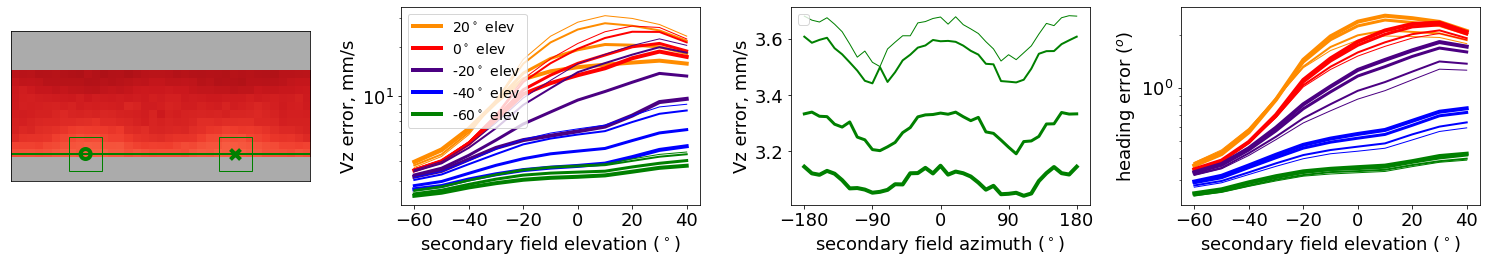

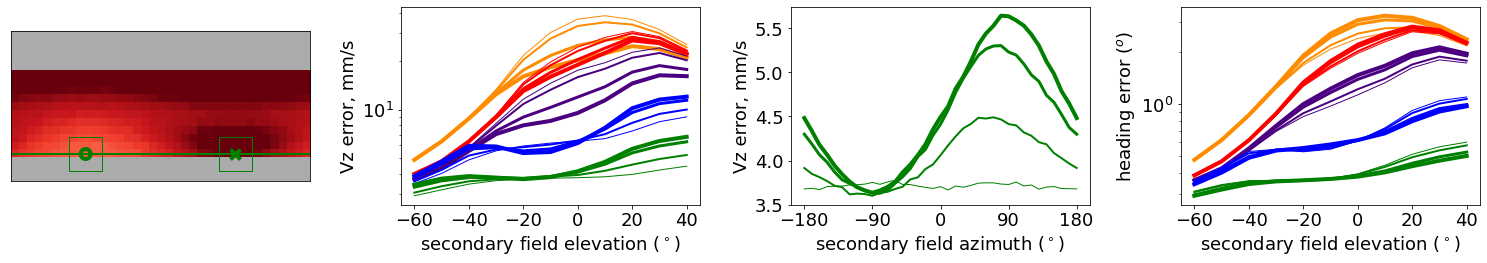

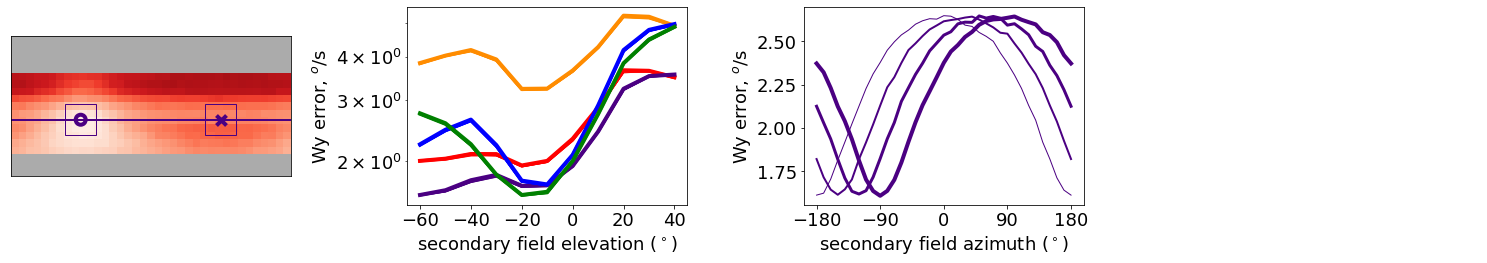

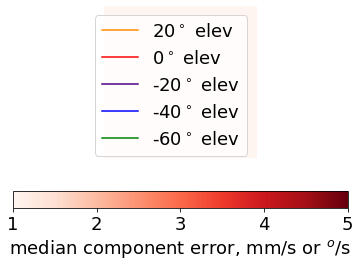

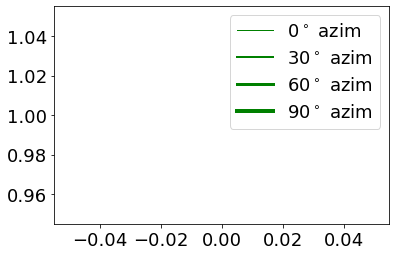

In [99]:
clim = [1,5]
logscale=False
model = 'LK'
bestelevtrans = -1
bestelevrot = 2
showcondition(model,'saccadictranslation',comp='Vz',ntrials=10000,bestelev=bestelevtrans,
              logscale=logscale,firstplot=False,clim=clim)
showcondition(model,'continuousswim',comp='Vz',ntrials=1000,bestelev=bestelevtrans,
              logscale=logscale,firstplot=False,labelsecondplot=False,clim=clim)

showcondition(model,'continuousswim',comp='Wy',ntrials=10000,bestelev=bestelevrot,
              logscale=logscale,firstplot=False,labelsecondplot=False,clim=clim,hbar=True)

No handles with labels found to put in legend.


(2.526275965598092, 40.18172523940691)
(5.037593048027457, 6.374162043826521)
(0.3769261424226193, 3.597144633628575)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


(3.083490358822479, 47.40489184965944)
(5.501438439403999, 9.253107431098348)
(0.45792000642773295, 4.300977875252546)
(2.6638750330426744, 5.9428826377577035)
(2.3300391172288917, 4.237512747108926)
(0.0, 1.0)


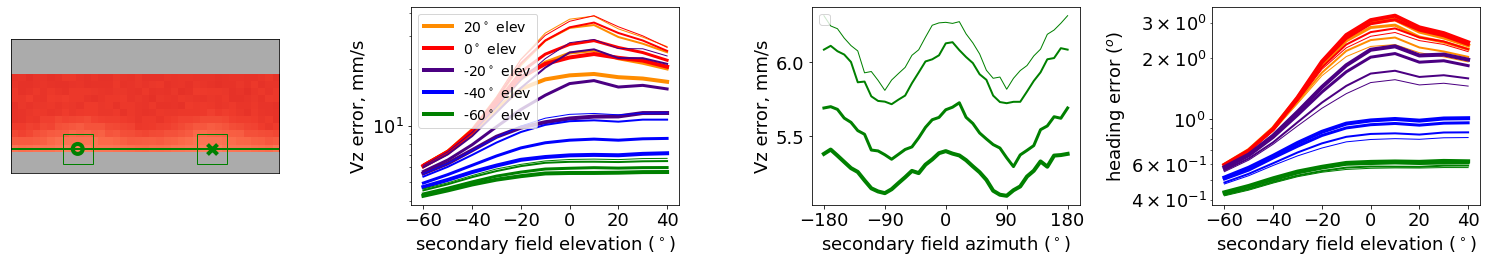

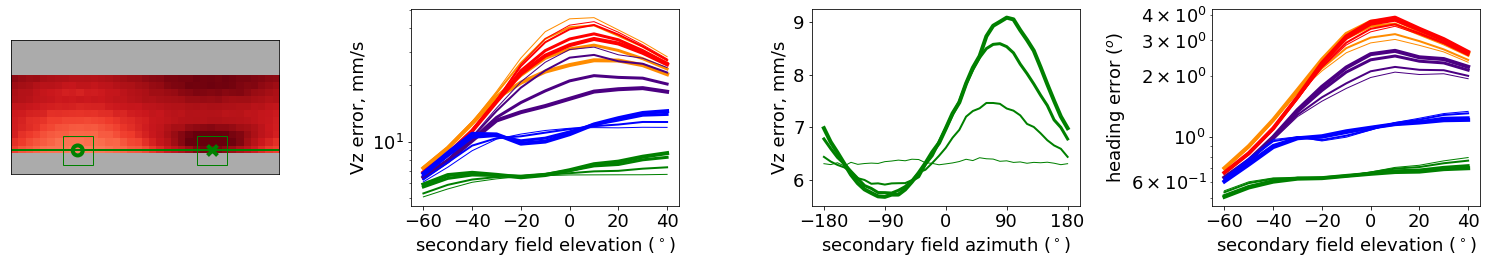

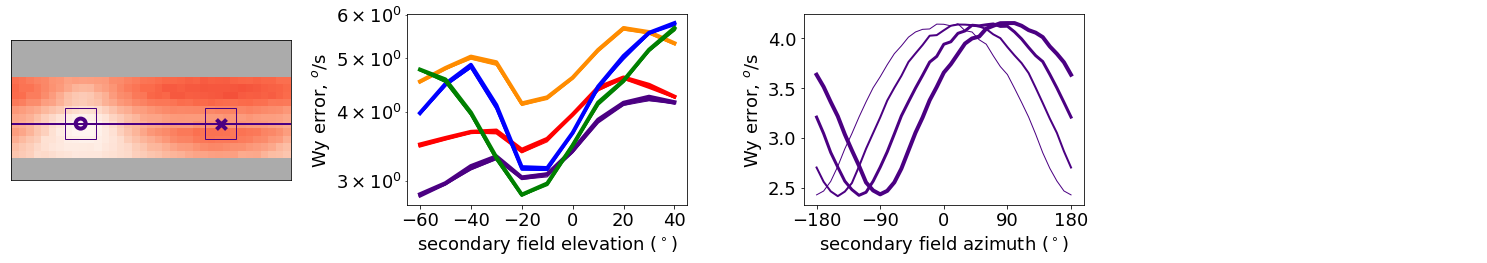

In [100]:
clim = [2,10]
logscale=False
model = 'FSloose'
bestelevtrans = -1
bestelevrot = 2
showcondition(model,'saccadictranslation',comp='Vz',ntrials=10000,bestelev=bestelevtrans,
              logscale=logscale,firstplot=False,clim=clim)
showcondition(model,'continuousswim',comp='Vz',ntrials=1000,bestelev=bestelevtrans,
              logscale=logscale,firstplot=False,labelsecondplot=False,clim=clim)
showcondition(model,'continuousswim',comp='Wy',ntrials=10000,bestelev=bestelevrot,
              logscale=logscale,firstplot=False,labelsecondplot=False,clim=clim)

No handles with labels found to put in legend.


(2.7027451644139107, 30.266177526302062)
(4.662760135991554, 5.939670445173145)
(0.3579977853703892, 2.6174089878695743)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


(3.2003179519518445, 37.163036474270015)
(4.963475751687411, 8.562324770748978)
(0.43430095065040336, 3.315905358622986)
(2.301047279033012, 5.4732064221734475)
(1.9696411186463716, 3.584684289727712)
(0.0, 1.0)


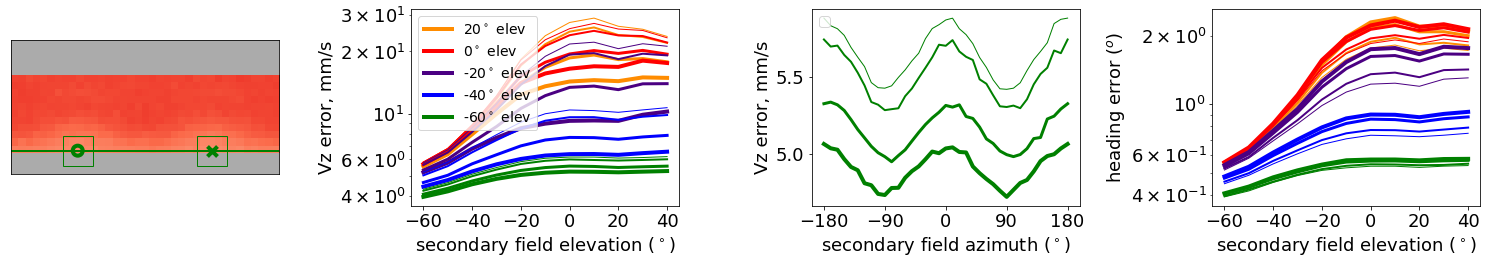

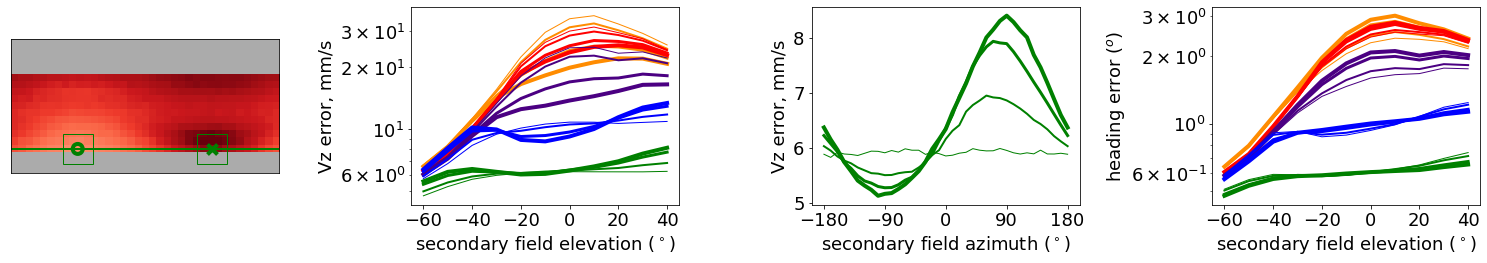

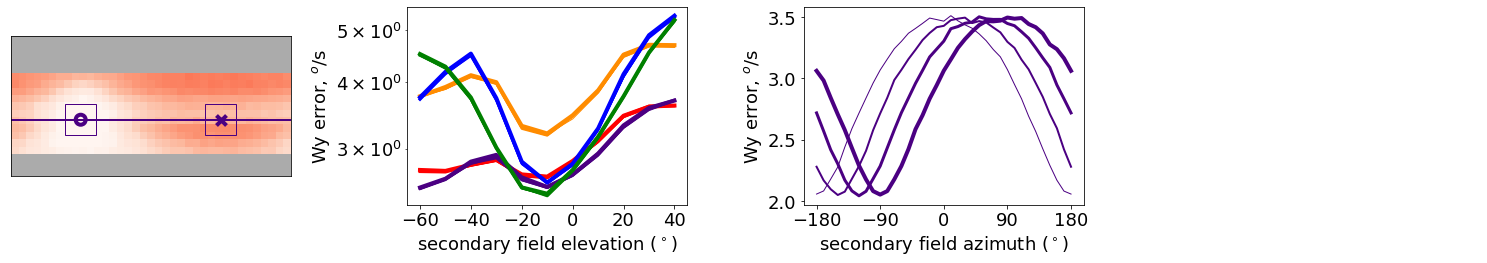

In [101]:
clim = [2,10]
logscale=False
model = 'FStight'
bestelevtrans = -1
bestelevrot = 2 #TODO: check
showcondition(model,'saccadictranslation',comp='Vz',ntrials=10000,bestelev=bestelevtrans,
              logscale=logscale,firstplot=False,clim=clim)
showcondition(model,'continuousswim',comp='Vz',ntrials=1000,bestelev=bestelevtrans,
              logscale=logscale,firstplot=False,labelsecondplot=False,clim=clim)
showcondition(model,'continuousswim',comp='Wy',ntrials=10000,bestelev=bestelevrot,
              logscale=logscale,firstplot=False,labelsecondplot=False,clim=clim)

No handles with labels found to put in legend.


(1.0005869382581942, 32.642049782493814)
(3.011131403281577, 3.712707668074553)
(0.21583458274116277, 2.881318890469972)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


incompatible behavior and component


No handles with labels found to put in legend.


(1.1329132704835514, 40.356666115287766)
(3.4997435114002733, 5.742264124193034)
(0.26039424471523104, 3.6744296474415274)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
No handles with labels found to put in legend.


(1.4084507660957226, 5.426499866048832)
(2.1199083566546584, 3.560599497221694)
(0.0, 1.0)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


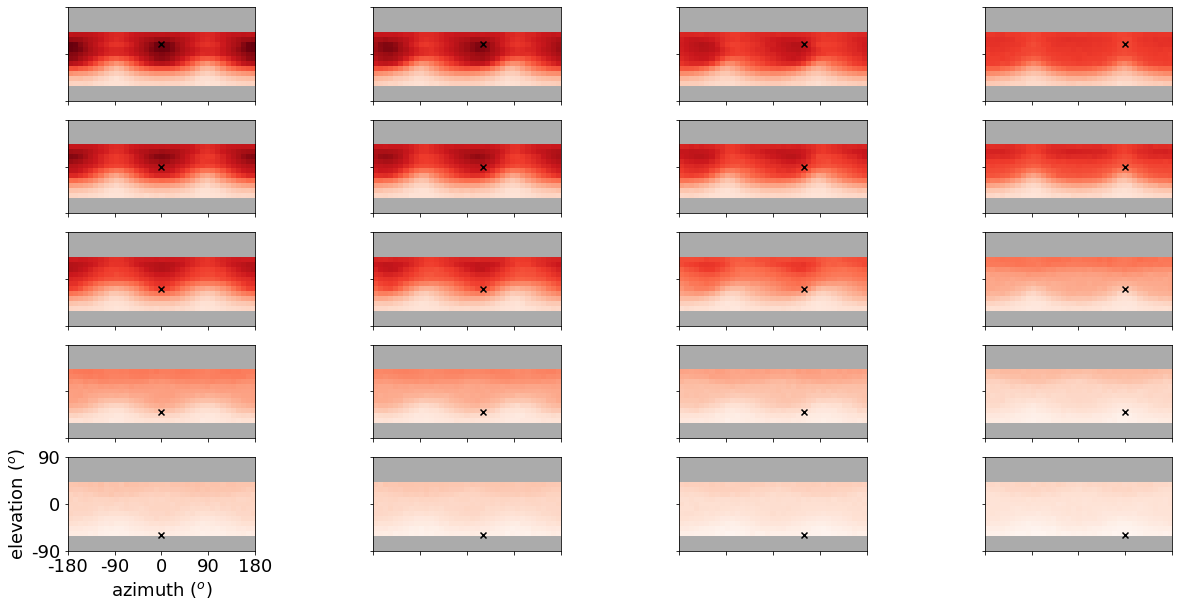

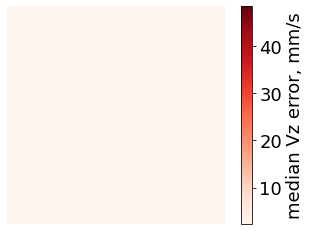

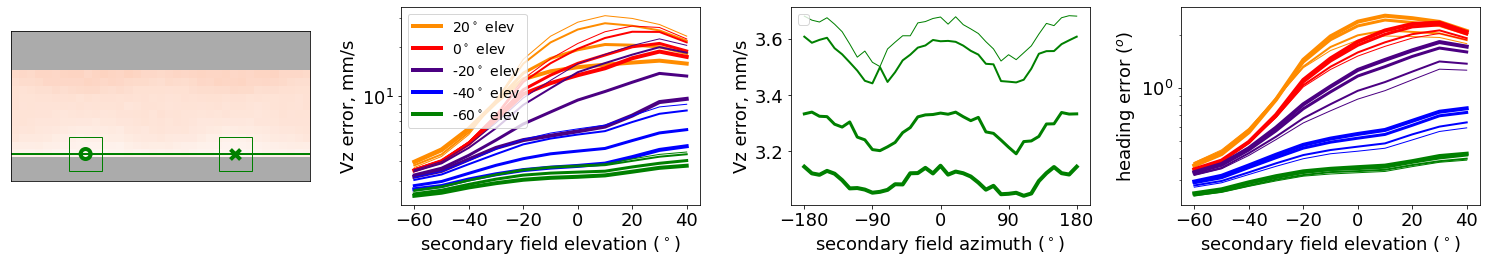

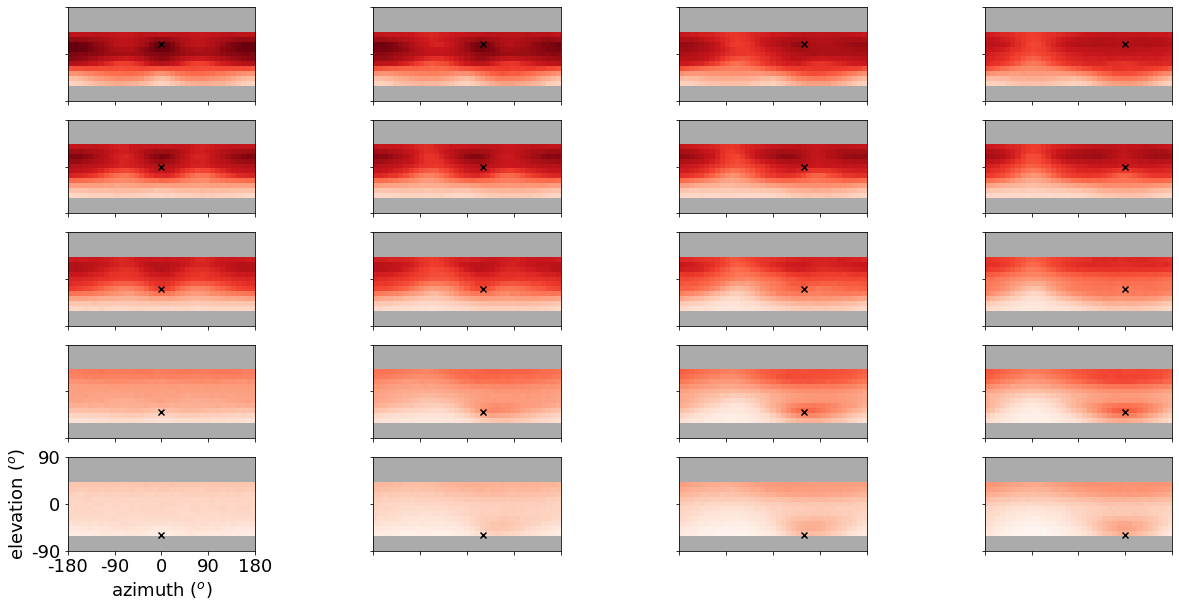

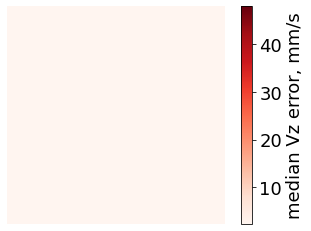

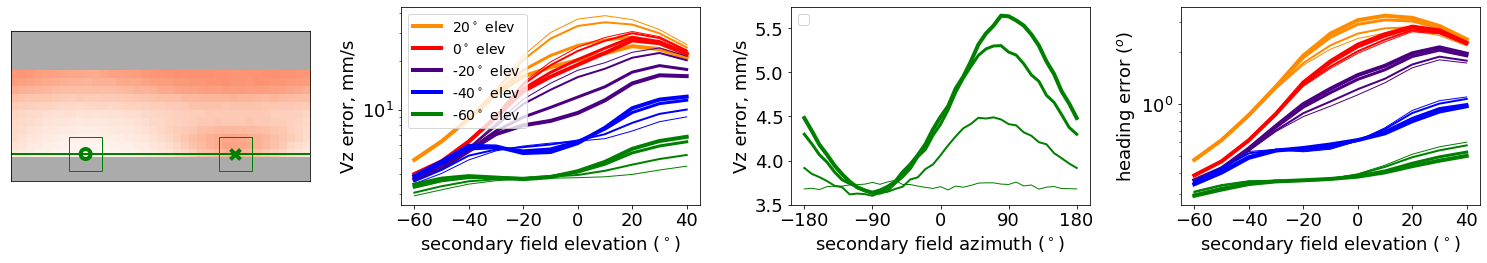

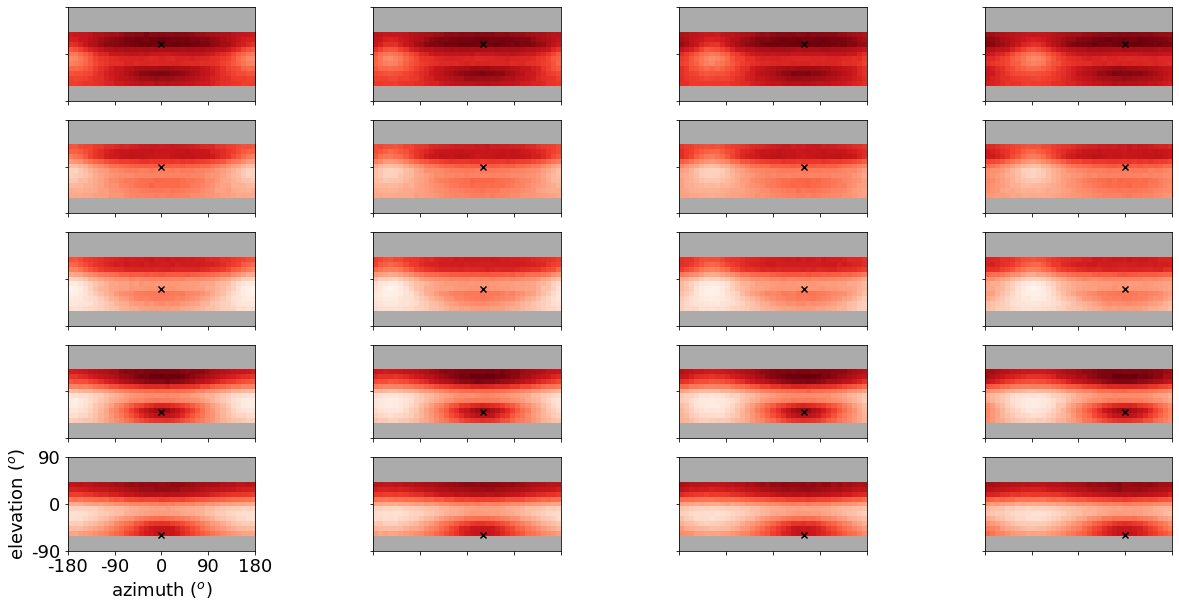

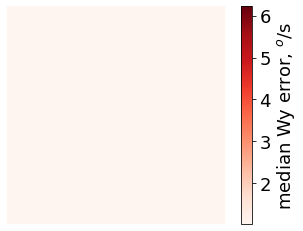

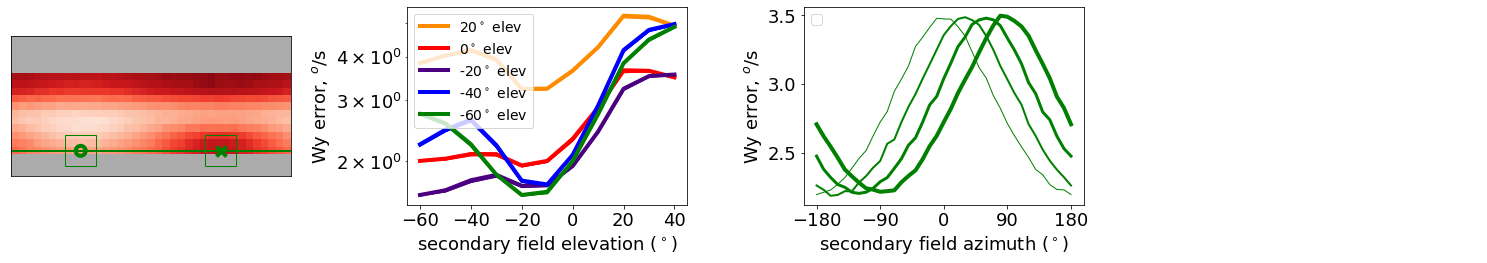

In [108]:
# show heat maps for S4 and S5

model = 'LK'
for behavior in ['saccadictranslation','continuousswim']:
    for comp in ['Vz','Wy']:
        showcondition(model,behavior,comp=comp,ntrials=1000,bestelev=-1,
              logscale=False,firstplot=True)

In [ ]:
# show global errors

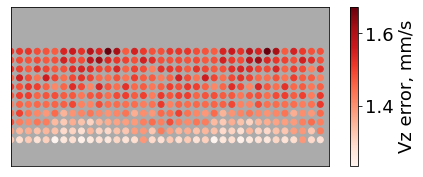

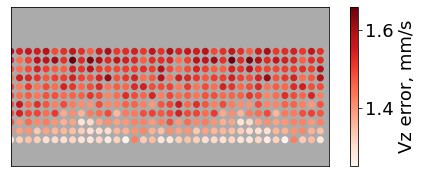

In [20]:
allfiles = os.listdir(datadir)

behaviors = ['saccadictranslation','continuousswim']
nlocs = 198

for behavior in behaviors:
    files = [file for file in allfiles if behavior in file]

    running_sum = np.zeros(nlocs)
    running_count = np.zeros(nlocs)
    repeats = 0
    for file in files:
        errs = np.load(datadir+file)
        #if errs['repeats'] < 500:
        #    continue
        running_sum = running_sum+errs['running_sum']
        running_count = running_count+errs['running_count']
        repeats = repeats+errs['repeats']
        
    # convert units
    running_sum = running_sum*1000

    plt.figure(figsize= [6.4, 2.8])
    ax = plt.axes()
    plt.axis('equal')
    plt.scatter(errs['thetas'],errs['alphas'],c=running_sum/running_count,cmap='Reds')

    plt.scatter(errs['thetas']-np.pi,errs['alphas'],c=running_sum/running_count,cmap='Reds')

    ax.set_facecolor("#ababab")
    ax.set_box_aspect(1/2)

    plt.xlim(-np.pi,np.pi)
    plt.ylim(-np.pi/2,np.pi/2)
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)

    #plt.title(f'{behavior}, {repeats} repeats')
    plt.tight_layout()
    plt.colorbar(label='Vz error, mm/s')
    
    plt.savefig(f'./final_plots/LK_fishflow_analysis_global_{behavior}_Vz.png', format='png',dpi=300)
    plt.savefig(f'./final_plots/LK_fishflow_analysis_global_{behavior}_Vz.eps', format='eps',dpi=300)

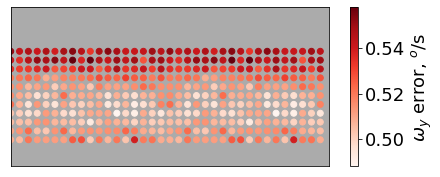

In [21]:
# Wy global heat map

allfiles = os.listdir(datadir)

behaviors = ['continuousswim']
nlocs = 198

for behavior in behaviors:
    files = [file for file in allfiles if behavior in file]

    running_sum = np.zeros(nlocs)
    running_count = np.zeros(nlocs)
    repeats = 0
    for file in files:
        errs = np.load(datadir+file)
        #if errs['repeats'] < 500:
        #    continue
        for repeat in range(errs['repeats']):
            err_Wy = errs['all_err'][repeat][2]
            running_sum[errs['all_subset_inds'][repeat]] = running_sum[errs['all_subset_inds'][repeat]] + err_Wy
            running_count[errs['all_subset_inds'][repeat]] = running_count[errs['all_subset_inds'][repeat]] +1
        repeats = repeats + errs['repeats']
    
    # convert units
    running_sum = running_sum*180/np.pi

    plt.figure(figsize= [6.4, 2.8])
    ax = plt.axes()
    plt.axis('equal')
    plt.scatter(errs['thetas'],errs['alphas'],c=running_sum/running_count,cmap='Reds')

    plt.scatter(errs['thetas']-np.pi,errs['alphas'],c=running_sum/running_count,cmap='Reds')

    ax.set_facecolor("#ababab")
    ax.set_box_aspect(1/2)

    plt.xlim(-np.pi,np.pi)
    plt.ylim(-np.pi/2,np.pi/2)
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)

    #plt.title(f'{behavior}, {repeats} repeats')
    plt.tight_layout()
    plt.colorbar(label='$\omega_y$ error, $^o$/s')
    
    plt.savefig(f'./final_plots/LK_fishflow_analysis_global_{behavior}_Wy.png', format='png',dpi=300)
    plt.savefig(f'./final_plots/LK_fishflow_analysis_global_{behavior}_Wy.eps', format='eps',dpi=300)

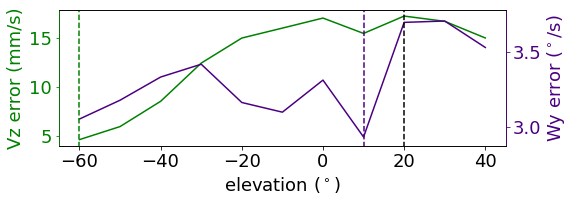

In [93]:
# discussion figure -- LKmodified4 noise model reduces sparsity in upper field

errs = np.load('./fish_simulation_files/LKmodified4/continuousswim/20.0elev_90.0azim_10000trials_20220723-075640.npz')['errs']

fig,ax1 = plt.subplots(figsize=(8,2.5))
pitchesdeg = np.linspace(40,-60,11)
ax1.plot(pitchesdeg,np.nanmean(1000*errs[:,:,1],axis=1),'g')
ax1.set_ylabel('Vz error (mm/s)',color='g')
ax2 = ax1.twinx()
ax2.plot(pitchesdeg,np.nanmean(180/np.pi*errs[:,:,2],axis=1),'indigo')
ax2.set_ylabel('Wy error ($^\circ$/s)',color='indigo')
ax1.set_xlabel('elevation ($^\circ$)')
plt.plot([20,20],[0,100],'--k')
plt.plot([10,10],[0,100],'--',color='indigo')
plt.plot([-60,-60],[0,100],'--g')
plt.ylim([.98*min(np.nanmean(180/np.pi*errs[:,:,2],axis=1)),1.02*max(np.nanmean(180/np.pi*errs[:,:,2],axis=1))])


ax2.spines['right'].set_color('indigo')
ax2.spines['left'].set_color('g')
ax2.tick_params(axis='y',colors='indigo')
ax1.tick_params(axis='y',colors='g')

plt.savefig(f'./final_plots/retinal_sampling_plot.png', format='png',dpi=300)
plt.savefig(f'./final_plots/retinal_sampling_plot.eps', format='eps',dpi=300)